# **Prediction with Regression**

## Objectives

*   Fit and evaluate a regression model to predict tenure levels for a prospect that will likely churn


## Inputs

* outputs/datasets/collection/TelcoCustomerChurn.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in their respective notebooks.

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict tenure
* labels map
* Feature Importance Plot


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [11]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Student-Performance'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [12]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [13]:
current_dir = os.getcwd()
current_dir

'/workspace'

-----

# Load data

Section 1 content

In [14]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/StudentPerformance.csv")
      )

print(df.shape)
df.head(3)

(6607, 20)


,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74


---

# ML Pipline: Regressor

## Create ML pipeline 

In [15]:
from sklearn.pipeline import Pipeline

# Cleaning
from feature_engine.imputation import CategoricalImputer

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.transformation import YeoJohnsonTransformer
from feature_engine.discretisation import EqualFrequencyDiscretiser 

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor


In [7]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([
        ('categorical_imputer', CategoricalImputer(imputation_method='missing',
                                                    fill_value='Missing',
                                                    variables=['Teacher_Quality', 'Parental_Education_Level', 'Distance_from_Home'])),

        ("Ordinal_Encoder", OrdinalEncoder(encoding_method='arbitrary',
                                           variables=['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities',
                                                      'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality',
                                                      'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level',
                                                      'Distance_from_Home', 'Gender'])),
        
        ("YeoJohnson", YeoJohnsonTransformer(variables=['Attendance', 'Tutoring_Sessions'])),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

Custom Class for hyperparameter optimisation

In [12]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches


---

## Split Train and Test Set

In [16]:
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
pipeline_taget_cleaning = Pipeline([
      ('efd', EqualFrequencyDiscretiser(q=7, variables=['Exam_Score'] ))
])

df_target_bins = pipeline_taget_cleaning.fit_transform(df)

target_span = pipeline_taget_cleaning['efd'].binner_dict_

# df.head()

# sns.countplot(data=df_target_bins, x='Exam_Score')
# plt.show()


X = df_target_bins.drop(['Exam_Score'], axis=1) # Defining the features
y = df_target_bins['Exam_Score'] # Defining the the target for the prediction

X_train, X_test, y_train, y_test = train_test_split(
     X,
     y,
     test_size=0.2,
     random_state=0
 )

print("* Train set:", X_train.shape, y_train.shape,
       "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (5285, 19) (5285,) 
* Test set: (1322, 19) (1322,)


In [17]:
print(target_span)

{'Exam_Score': [-inf, 63.0, 65.0, 66.0, 68.0, 69.0, 71.0, inf]}


## Grid Search CV - Sklearn

In [13]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}


params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a hyperparameter optimisation search using default hyperparameters

In [ ]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)

Checking the resulte

In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

~~Since LinearRegssion doesn't have any Hyperparameter GradientBoostRegressor will be used to explor if the Model be improved~~
In the first attempt the taget had not been adjusted which was leading to a lower r^2 mean value then reqiered in the bussnies case (0.8). After the target have been divided in 7 equivalized bins the model with the best resulte is LinearRegression. Since, as in the first attempt, LinearRegression doesnot have any Hypoparameters the model XGBRegressor has been used to explore if the r-squer value can be improved. 

In [16]:
models_search = {
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_search = {
    "XGBRegressor": {
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.1, 0.01, 0.001],
        'model__subsample': [0.5, 0.7, 1],
        'model__min_child_weight': [1, 3, 6]
        # 'model__n_estimators': [100, 200, 300],
        # 'model__learning_rate': [0.01, 0.05, 0.1],
        # 'model__max_depth': [3, 4, 5],
        # 'model__subsample': [0.8, 0.9, 1.0],
        # 'model__min_samples_split': [2, 5, 10],
        # 'model__max_features': [None, 'sqrt', 'log2']
    }
}

In [ ]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)

In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

**Rerwite**
Low mean score even by using hyperparameters to improv it to min 0.8
Therefore i will try a 

In [18]:
def PipelineOptimization_KNN(model):
    steps = [
        ('categorical_imputer', CategoricalImputer(imputation_method='missing',
                                                    fill_value='Missing',
                                                    variables=['Teacher_Quality', 'Parental_Education_Level', 'Distance_from_Home'])),
        ("Ordinal_Encoder", OrdinalEncoder(encoding_method='arbitrary',
                                           variables=['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities',
                                                      'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality',
                                                      'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level',
                                                      'Distance_from_Home', 'Gender'])),
        ("YeoJohnson", YeoJohnsonTransformer(['Attendance', 'Tutoring_Sessions'])),
        ("feat_scaling", StandardScaler())
    ]
    
    # Add feature selection step only if the model has feature_importances_ or coef_ attributes
    if hasattr(model, 'feature_importances_') or hasattr(model, 'coef_'):
        steps.append(("feat_selection", SelectFromModel(model)))

    steps.append(("model", model))
    
    pipeline_base = Pipeline(steps)
    return pipeline_base

The max value is 0.6622206936069117 and as the k-value 12


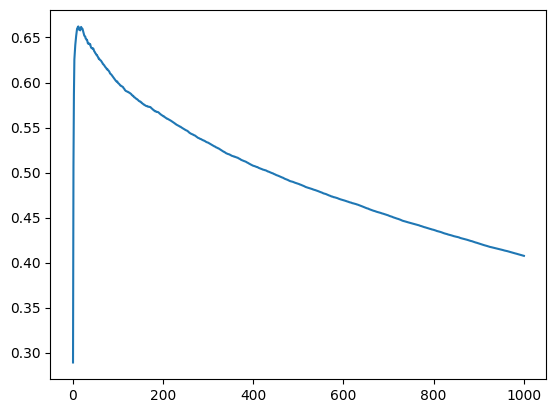

In [27]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np


def Predict_k_value(X_train, y_train, X_test, y_test, k_max):
    knn_r_score=[]

    for i in range(1, k_max):
        # Create and fit the KNeighborsRegressor
        knn_pipeline = PipelineOptimization_KNN(KNeighborsRegressor(n_neighbors=i)) #, weights='distance', algorithm='ball_tree'))
        knn_pipeline.fit(X_train, y_train)

        # Predict on the test data
        y_pred = knn_pipeline.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        knn_r_score.append(r2)

    print(f'The max value is {max(knn_r_score)} and as the k-value {knn_r_score.index(max(knn_r_score))}')
    plt.plot(range(1, k_max), knn_r_score)
    plt.show

Predict_k_value(X_train, y_train, X_test, y_test, 201)

In [20]:
max(knn_r_score)

0.6622206936069117

## Create ML pipeline with Missing values to 

In [9]:
from feature_engine.imputation import CategoricalImputer

def PipelineOptimization(model):
    pipeline_base = Pipeline([
        ('categorical_imputer', CategoricalImputer(imputation_method='frequent',
                                                    variables=['Teacher_Quality', 'Parental_Education_Level', 'Distance_from_Home'])),

        ("Ordinal_Encoder", OrdinalEncoder(encoding_method='arbitrary',
                                           variables=['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities',
                                                      'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality',
                                                      'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level',
                                                      'Distance_from_Home', 'Gender'])),
        
        ("YeoJohnson", YeoJohnsonTransformer(variables=['Attendance', 'Tutoring_Sessions'])),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

In [ ]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)

In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* In case you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
